In [1]:
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm

from eofs.xarray import Eof
from scipy import stats
from scipy.signal import detrend
from sklearn.utils import resample
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

In [3]:
data_path = ('/mnt/nas153/Roshan/PhD_Project_3/ERA5_UVTH/')
uwind =[]
for year in range(1973, 2023):
    print(year)
    file_path = os.path.join(data_path,f'{year}_UVTH.nc')
    u = xr.open_dataset(file_path)
    u200=u.sel(level=200)
    uwnd = u200.resample(time='D').mean()
    uwind.append(uwnd)
    
uwind_ds = xr.concat(uwind,dim='time')
uwind_ds['dayofyear'] = uwind_ds['time.dayofyear']
leap_years = (uwind_ds['time.year'] % 4 == 0) & ((uwind_ds['time.year'] % 100 != 0) | (uwind_ds['time.year'] % 400 == 0))
uwind_ds['dayofyear'] = xr.where(leap_years & (uwind_ds['time.month'] > 2),
                                               uwind_ds['dayofyear'] - 1,
                                               uwind_ds['dayofyear'])    

1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [4]:
UVTH_200_Ano = uwind_ds.groupby('dayofyear') - uwind_ds.groupby('dayofyear').mean(dim='time')

Uwind_200_Ano_SS = UVTH_200_Ano.u.sel(latitude=slice(50,20), longitude=slice(40,90))
Uwind_200_Ano_SS = Uwind_200_Ano_SS.drop_vars(['dayofyear'])
Uwind_200_Ano_SS_yearwise = Uwind_200_Ano_SS.groupby('time.year').mean(dim='time')
#detrended_data = detrend(Uwind_200_Ano_SS_yearwise, axis=0, type='linear')

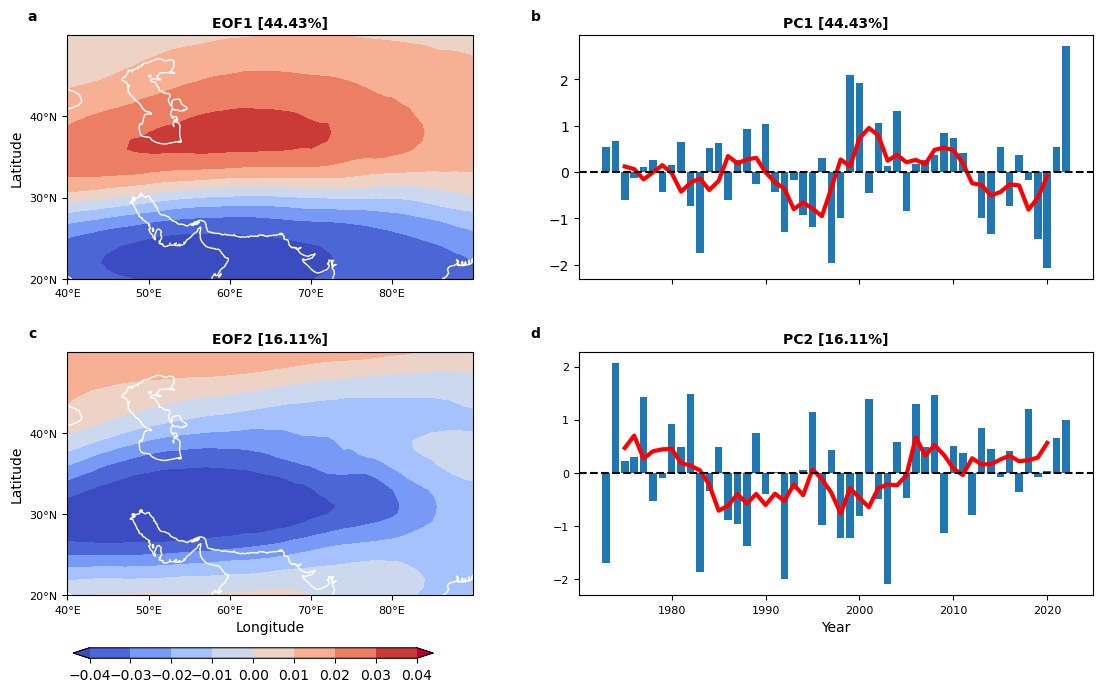

In [5]:
data1 = xr.Dataset({"u": (('time','lat','lon'), Uwind_200_Ano_SS_yearwise.values)},
                           coords={'time':Uwind_200_Ano_SS_yearwise.year.values,'lat': Uwind_200_Ano_SS_yearwise.latitude.values, 'lon': Uwind_200_Ano_SS_yearwise.longitude.values})

coslat = np.cos(np.deg2rad(data1.u.lat.values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(data1['u'],weights=wgts)

eofs = solver.eofs(neofs=3)
pcs = solver.pcs(npcs=3, pcscaling=1)
eofs=eofs*-1
pcs=pcs*-1

var_frac = solver.varianceFraction(neigs=3)*100


######
fig = plt.figure(figsize=(12,7))

clev=np.arange(-0.04,0.041,0.01)
ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), fig=fig, projection=ccrs.PlateCarree())

cf_plot = ax1.contourf(eofs.lon, eofs.lat, eofs.sel(mode=0),clev,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')

ax1.add_feature(cfeature.COASTLINE, edgecolor='white')

ax1.set_xticks(np.arange(40,90,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(20,50,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax1.tick_params(axis='both', which='major', labelsize=8)

#ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
vf = var_frac.sel(mode=0).values
ax1.set_title(f'EOF1 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

####

ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), fig=fig, projection=ccrs.PlateCarree())

cf_plot = ax2.contourf(eofs.lon, eofs.lat, eofs.sel(mode=1),clev,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')

ax2.add_feature(cfeature.COASTLINE, edgecolor='white')

ax2.set_xticks(np.arange(40,90,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)

ax2.set_yticks(np.arange(20,50,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax2.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax2.tick_params(axis='both', which='major', labelsize=8)

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
 
vf = var_frac.sel(mode=1).values
ax2.set_title(f'EOF2 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax2.text(-0.075, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

###

ax3 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), fig=fig)

pc1 = pcs.sel(mode=0)
pc1_10year =  pc1.rolling(time=5,center='True').mean()
ax3.bar(pc1.time,pc1,color='tab:blue',linewidth=1)
ax3.plot(pc1_10year.time, pc1_10year.values, linewidth=3, color='red') 
ax3.axhline(0, color='k', linestyle='--')
ax3.set_xticklabels([])
vf = var_frac.sel(mode=0).values
ax3.set_title(f'PC1 [{vf:.2f}%]', fontdict={'fontsize':10, 'fontweight': 'bold'})
ax3.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')

###
ax4 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), fig=fig)

pc2 = pcs.sel(mode=1)
pc2_10year =  pc2.rolling(time=5,center='True').mean()
ax4.bar(pc2.time,pc2,color='tab:blue',linewidth=1)
ax4.plot(pc2_10year.time, pc2_10year.values, linewidth=3, color='red') 
ax4.axhline(0, color='k', linestyle='--')
ax4.set_xlabel('Year')
ax4.tick_params(axis='both', which='major', labelsize=8)
vf = var_frac.sel(mode=1).values
ax4.set_title(f'PC2 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax4.text(-0.075, 1.05, 'd',verticalalignment='bottom', horizontalalignment='right',transform=ax4.transAxes,color='k', weight='bold')

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.3)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.1, 0.01, 0.3, 0.015])

# Draw the colorbar
cbar=fig.colorbar(cf_plot, cax=cbar_ax,orientation='horizontal')

plt.savefig('SFigure_8.png', dpi=600,bbox_inches='tight')

plt.savefig('SFigure_8.pdf', dpi=600,bbox_inches='tight')

In [6]:
HW_Aspects = xr.open_dataset('Heatwave_Frequency,Duration_Cumulative_Heat_New_Method_1973_2022.nc')
HWF = HW_Aspects.HWF
HWD = HW_Aspects.HWD
HWI = HW_Aspects.HWI

In [7]:
## HWF & SWJ (PC1)
# Initialize numpy arrays to store coefficients and p-values
corr = np.zeros([HWF.latitude.size,HWF.longitude.size])
corr[:] = np.nan
p_values= np.zeros([HWF.latitude.size,HWF.longitude.size])
p_values[:] = np.nan

# Iterate over each grid point
for lat_idx, lat in enumerate(HWF.latitude):
    for lon_idx, lon in enumerate(HWF.longitude):
        # Extract HWF and PC1 values for the current grid point
        HWF_grid = HWF.sel(latitude=lat, longitude=lon).values
        PC1_grid =pc1.values
        
        # Check if all values in the HWF grid are NaN
        if np.all(np.isnan(HWF_grid)):
            continue  # Skip this grid point
        
        # Convert NaN values to zero
        HWF_grid[np.isnan(HWF_grid)] = 0
        
        #HWF_grid_detrended = detrend(HWF_grid, type='linear')
        
        corr_coef, p_value = stats.pearsonr(PC1_grid, HWF_grid)
        
        # Store coefficients
        corr[lat_idx, lon_idx] = corr_coef  # coefficient for PC1
        p_values[lat_idx, lon_idx] = p_value
               
HWF_SWJ_Corr = xr.Dataset({"corr": (('latitude','longitude'), corr),
                           "pval": (('latitude','longitude'), p_values)},
                           coords={'latitude': HWF.latitude, 'longitude': HWF.longitude})

pvalue_mask = np.where(HWF_SWJ_Corr.pval < 0.05, 1, np.nan)

####

HWF_NCI = HWF.sel(latitude=slice(30,20),longitude=slice(70,80)).mean(dim=['latitude','longitude'])
#HWF_NCI_Detrended = detrend(HWF_NCI, axis=0, type='linear')

x=pc1.values
y=HWF_NCI.values

# Sort x and y
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Perform linear regression
slope, intercept, r_value, p_value, _ = stats.linregress(x_sorted, y_sorted)
r_squared = r_value ** 2
# Compute bootstrapped confidence intervals for linear fit
n_boots = 1000
fits = []
r_squared_boots = []
for _ in range(n_boots):
    x_boot, y_boot = resample(x_sorted, y_sorted)
    slope_boot, intercept_boot, r_value_boot, _, _ = stats.linregress(x_boot, y_boot)
    fits.append(slope_boot * x_sorted + intercept_boot)
    r_squared_boot = r_value_boot ** 2
    r_squared_boots.append(r_squared_boot)

fit_ci = np.percentile(fits, [5, 95], axis=0)
r_squared_boot = np.percentile(r_squared_boots, [5, 95])

##

HWF_BB = HWF.sel(latitude=slice(40,20),longitude=slice(50,90)).mean(dim=['latitude','longitude'])
#HWF_NCI_Detrended = detrend(HWF_NCI, axis=0, type='linear')

x_BB=pc1.values
y_BB=HWF_BB.values

# Sort x and y
sorted_indices = np.argsort(x_BB)
x_sorted_BB = x_BB[sorted_indices]
y_sorted_BB = y_BB[sorted_indices]

# Perform linear regression
slope_BB, intercept_BB, r_value_BB, p_value_BB, _ = stats.linregress(x_sorted_BB, y_sorted_BB)
r_squared_BB = r_value_BB ** 2

# Compute bootstrapped confidence intervals for linear fit
n_boots_BB = 1000
fits_BB = []
r_squared_boots_BB = []
for _ in range(n_boots_BB):
    x_boot_BB, y_boot_BB = resample(x_sorted_BB, y_sorted_BB)
    slope_boot_BB, intercept_boot_BB, r_value_boot_BB, _, _ = stats.linregress(x_boot_BB, y_boot_BB)
    fits_BB.append(slope_boot_BB * x_sorted_BB + intercept_boot_BB)
    r_squared_boot_BB = r_value_boot_BB ** 2
    r_squared_boots_BB.append(r_squared_boot_BB)

fit_ci_BB = np.percentile(fits_BB, [5, 95], axis=0)
r_squared_boot_BB = np.percentile(r_squared_boots_BB, [5, 95])


In [8]:
print(p_value)

8.290214836392241e-05


8.56531879147569e-05
0.00023750096313157783


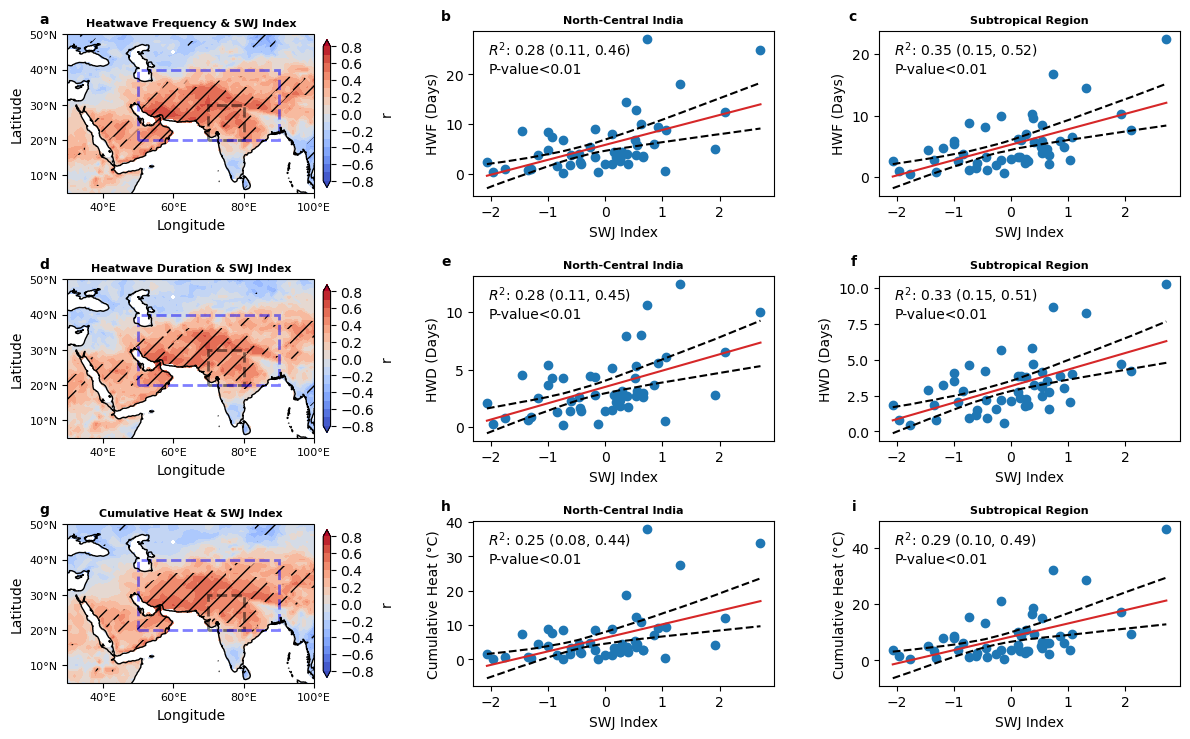

In [9]:
########
original_cmap = plt.get_cmap('coolwarm')
new_values = np.linspace(0.51, 1, 256)
custom_cmap = ListedColormap(original_cmap(new_values), name='truncated_bwr')

fig = plt.figure(figsize=(12,7.5))

ax1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), fig=fig, projection=ccrs.PlateCarree())

clevs = np.arange(-0.8,0.85,0.1)
cf_plot = ax1.contourf(HWF_SWJ_Corr.longitude, HWF_SWJ_Corr.latitude, HWF_SWJ_Corr.corr,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')
cbar = fig.colorbar(cf_plot,ax=ax1,orientation='vertical', pad=0.03, shrink=0.9)
cbar.set_label('r')
hatch_plot = ax1.contourf(HWF_SWJ_Corr.longitude, HWF_SWJ_Corr.latitude, pvalue_mask, hatches=['//'],cmap='gray', alpha=0,  transform=ccrs.PlateCarree())

rect_coords = [70, 20, 80, 30]
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='k', facecolor='none',alpha=0.5, transform=ccrs.PlateCarree())
ax1.add_patch(rect)

rect_coords = [50, 20, 90, 40]
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='b', facecolor='none',alpha=0.5, transform=ccrs.PlateCarree())
ax1.add_patch(rect)
ax1.coastlines()

# Longitude labels
ax1.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax1.set_yticks(np.arange(0,60,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_extent([30, 100, 5, 50],crs=ccrs.PlateCarree())

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Heatwave Frequency & SWJ Index',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

#####
ax2 = plt.subplot2grid(shape=(3, 3), loc=(0, 1), fig=fig)
# Plot scatter plot
ax2.scatter(x_sorted, y_sorted, label='Data')

# Plot linear fit
ax2.plot(x_sorted, slope * x_sorted + intercept, color='tab:red')

# Plot confidence interval
ax2.plot(x_sorted, fit_ci[0], color='black', linestyle='--')
ax2.plot(x_sorted, fit_ci[1], color='black', linestyle='--')

# Add text at top right
text = f'$R^2$: {r_squared:.2f} ({r_squared_boot[0]:.2f}, {r_squared_boot[1]:.2f})\nP-value<0.01'
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, ha='left', va='top')

# Add labels and title
ax2.set_xlabel('SWJ Index')
ax2.set_ylabel('HWF (Days)')
 
# Title
ax2.set_title('North-Central India',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax2.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

#####
ax3 = plt.subplot2grid(shape=(3, 3), loc=(0, 2), fig=fig)
# Plot scatter plot
ax3.scatter(x_sorted_BB, y_sorted_BB, label='Data')

# Plot linear fit
ax3.plot(x_sorted_BB, slope_BB * x_sorted_BB + intercept_BB, color='tab:red')

# Plot confidence interval
ax3.plot(x_sorted_BB, fit_ci_BB[0], color='black', linestyle='--')
ax3.plot(x_sorted_BB, fit_ci_BB[1], color='black', linestyle='--')

# Add text at top right
text = f'$R^2$: {r_squared_BB:.2f} ({r_squared_boot_BB[0]:.2f}, {r_squared_boot_BB[1]:.2f})\nP-value<0.01'
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, ha='left', va='top')

# Add labels and title
ax3.set_xlabel('SWJ Index')
ax3.set_ylabel('HWF (Days)')
 
# Title
ax3.set_title('Subtropical Region',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax3.text(-0.075, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')

###
###
## HWD & SWJ (PC1)
# Initialize numpy arrays to store coefficients and p-values
corr = np.zeros([HWD.latitude.size,HWD.longitude.size])
corr[:] = np.nan
p_values= np.zeros([HWD.latitude.size,HWD.longitude.size])
p_values[:] = np.nan

# Iterate over each grid point
for lat_idx, lat in enumerate(HWD.latitude):
    for lon_idx, lon in enumerate(HWD.longitude):
        # Extract HWD and PC1 values for the current grid point
        HWD_grid = HWD.sel(latitude=lat, longitude=lon).values
        PC1_grid =pc1.values
        
        # Check if all values in the HWD grid are NaN
        if np.all(np.isnan(HWD_grid)):
            continue  # Skip this grid point
        
        # Convert NaN values to zero
        HWD_grid[np.isnan(HWD_grid)] = 0
        
        #HWD_grid_detrended = detrend(HWD_grid, type='linear')
        
        corr_coef, p_value = stats.pearsonr(PC1_grid, HWD_grid)
        
        # Store coefficients
        corr[lat_idx, lon_idx] = corr_coef  # coefficient for PC1
        p_values[lat_idx, lon_idx] = p_value
               
HWD_SWJ_Corr = xr.Dataset({"corr": (('latitude','longitude'), corr),
                           "pval": (('latitude','longitude'), p_values)},
                           coords={'latitude': HWD.latitude, 'longitude': HWD.longitude})

pvalue_mask = np.where(HWD_SWJ_Corr.pval < 0.05, 1, np.nan)

####

HWD_NCI = HWD.sel(latitude=slice(30,20),longitude=slice(70,80)).mean(dim=['latitude','longitude'])
#HWD_NCI_Detrended = detrend(HWD_NCI, axis=0, type='linear')

x=pc1.values
y=HWD_NCI.values

# Sort x and y
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Perform linear regression
slope, intercept, r_value, p_value, _ = stats.linregress(x_sorted, y_sorted)
r_squared = r_value ** 2
print(p_value)
# Compute bootstrapped confidence intervals for linear fit
n_boots = 1000
fits = []
r_squared_boots = []
for _ in range(n_boots):
    x_boot, y_boot = resample(x_sorted, y_sorted)
    slope_boot, intercept_boot, r_value_boot, _, _ = stats.linregress(x_boot, y_boot)
    fits.append(slope_boot * x_sorted + intercept_boot)
    r_squared_boot = r_value_boot ** 2
    r_squared_boots.append(r_squared_boot)

fit_ci = np.percentile(fits, [5, 95], axis=0)
r_squared_boot = np.percentile(r_squared_boots, [5, 95])

##

HWD_BB = HWD.sel(latitude=slice(40,20),longitude=slice(50,90)).mean(dim=['latitude','longitude'])
#HWD_NCI_Detrended = detrend(HWD_NCI, axis=0, type='linear')

x_BB=pc1.values
y_BB=HWD_BB.values

# Sort x and y
sorted_indices = np.argsort(x_BB)
x_sorted_BB = x_BB[sorted_indices]
y_sorted_BB = y_BB[sorted_indices]

# Perform linear regression
slope_BB, intercept_BB, r_value_BB, p_value_BB, _ = stats.linregress(x_sorted_BB, y_sorted_BB)
r_squared_BB = r_value_BB ** 2

# Compute bootstrapped confidence intervals for linear fit
n_boots_BB = 1000
fits_BB = []
r_squared_boots_BB = []
for _ in range(n_boots_BB):
    x_boot_BB, y_boot_BB = resample(x_sorted_BB, y_sorted_BB)
    slope_boot_BB, intercept_boot_BB, r_value_boot_BB, _, _ = stats.linregress(x_boot_BB, y_boot_BB)
    fits_BB.append(slope_boot_BB * x_sorted_BB + intercept_boot_BB)
    r_squared_boot_BB = r_value_boot_BB ** 2
    r_squared_boots_BB.append(r_squared_boot_BB)

fit_ci_BB = np.percentile(fits_BB, [5, 95], axis=0)
r_squared_boot_BB = np.percentile(r_squared_boots_BB, [5, 95])

###
ax4 = plt.subplot2grid(shape=(3, 3), loc=(1, 0), fig=fig, projection=ccrs.PlateCarree())

clevs = np.arange(-0.8,0.85,0.1)
cf_plot = ax4.contourf(HWD_SWJ_Corr.longitude, HWD_SWJ_Corr.latitude, HWD_SWJ_Corr.corr,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')
cbar = fig.colorbar(cf_plot,ax=ax4,orientation='vertical', pad=0.03, shrink=0.9)
cbar.set_label('r')
hatch_plot = ax4.contourf(HWD_SWJ_Corr.longitude, HWD_SWJ_Corr.latitude, pvalue_mask, hatches=['//'],cmap='gray', alpha=0,  transform=ccrs.PlateCarree())

rect_coords = [70, 20, 80, 30]
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='k', facecolor='none',alpha=0.5, transform=ccrs.PlateCarree())
ax4.add_patch(rect)

rect_coords = [50, 20, 90, 40]
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='b', facecolor='none',alpha=0.5, transform=ccrs.PlateCarree())
ax4.add_patch(rect)
ax4.coastlines()

# Longitude labels
ax4.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax4.set_yticks(np.arange(0,60,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax4.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax4.tick_params(axis='both', which='major', labelsize=8)

ax4.set_extent([30, 100, 5, 50],crs=ccrs.PlateCarree())

ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.set_title('Heatwave Duration & SWJ Index',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax4.text(-0.075, 1.05, 'd',verticalalignment='bottom', horizontalalignment='right',transform=ax4.transAxes,color='k', weight='bold')

#####
ax5 = plt.subplot2grid(shape=(3, 3), loc=(1, 1), fig=fig)
# Plot scatter plot
ax5.scatter(x_sorted, y_sorted, label='Data')

# Plot linear fit
ax5.plot(x_sorted, slope * x_sorted + intercept, color='tab:red')

# Plot confidence interval
ax5.plot(x_sorted, fit_ci[0], color='black', linestyle='--')
ax5.plot(x_sorted, fit_ci[1], color='black', linestyle='--')

# Add text at top right
text = f'$R^2$: {r_squared:.2f} ({r_squared_boot[0]:.2f}, {r_squared_boot[1]:.2f})\nP-value<0.01'
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, ha='left', va='top')

# Add labels and title
ax5.set_xlabel('SWJ Index')
ax5.set_ylabel('HWD (Days)')
 
# Title
ax5.set_title('North-Central India',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax5.text(-0.075, 1.05, 'e',verticalalignment='bottom', horizontalalignment='right',transform=ax5.transAxes,color='k', weight='bold')

#####
ax6 = plt.subplot2grid(shape=(3, 3), loc=(1, 2), fig=fig)
# Plot scatter plot
ax6.scatter(x_sorted_BB, y_sorted_BB, label='Data')

# Plot linear fit
ax6.plot(x_sorted_BB, slope_BB * x_sorted_BB + intercept_BB, color='tab:red')

# Plot confidence interval
ax6.plot(x_sorted_BB, fit_ci_BB[0], color='black', linestyle='--')
ax6.plot(x_sorted_BB, fit_ci_BB[1], color='black', linestyle='--')

# Add text at top right
text = f'$R^2$: {r_squared_BB:.2f} ({r_squared_boot_BB[0]:.2f}, {r_squared_boot_BB[1]:.2f})\nP-value<0.01'
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, ha='left', va='top')

# Add labels and title
ax6.set_xlabel('SWJ Index')
ax6.set_ylabel('HWD (Days)')
 
# Title
ax6.set_title('Subtropical Region',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax6.text(-0.075, 1.05, 'f',verticalalignment='bottom', horizontalalignment='right',transform=ax6.transAxes,color='k', weight='bold')

###
## Cumulative Heat & SWJ (PC1)
# Initialize numpy arrays to store coefficients and p-values
corr = np.zeros([HWI.latitude.size,HWI.longitude.size])
corr[:] = np.nan
p_values= np.zeros([HWI.latitude.size,HWI.longitude.size])
p_values[:] = np.nan

# Iterate over each grid point
for lat_idx, lat in enumerate(HWI.latitude):
    for lon_idx, lon in enumerate(HWI.longitude):
        # Extract HWI and PC1 values for the current grid point
        HWI_grid = HWI.sel(latitude=lat, longitude=lon).values
        PC1_grid =pc1.values
        
        # Check if all values in the HWI grid are NaN
        if np.all(np.isnan(HWI_grid)):
            continue  # Skip this grid point
        
        # Convert NaN values to zero
        HWI_grid[np.isnan(HWI_grid)] = 0
        
        #HWI_grid_detrended = detrend(HWI_grid, type='linear')
        
        corr_coef, p_value = stats.pearsonr(PC1_grid, HWI_grid)
        
        # Store coefficients
        corr[lat_idx, lon_idx] = corr_coef  # coefficient for PC1
        p_values[lat_idx, lon_idx] = p_value
               
HWI_SWJ_Corr = xr.Dataset({"corr": (('latitude','longitude'), corr),
                           "pval": (('latitude','longitude'), p_values)},
                           coords={'latitude': HWI.latitude, 'longitude': HWI.longitude})

pvalue_mask = np.where(HWI_SWJ_Corr.pval < 0.05, 1, np.nan)

####

HWI_NCI = HWI.sel(latitude=slice(30,20),longitude=slice(70,80)).mean(dim=['latitude','longitude'])
#HWI_NCI_Detrended = detrend(HWI_NCI, axis=0, type='linear')

x=pc1.values
y=HWI_NCI.values

# Sort x and y
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Perform linear regression
slope, intercept, r_value, p_value, _ = stats.linregress(x_sorted, y_sorted)
r_squared = r_value ** 2
print(p_value)

# Compute bootstrapped confidence intervals for linear fit
n_boots = 1000
fits = []
r_squared_boots = []
for _ in range(n_boots):
    x_boot, y_boot = resample(x_sorted, y_sorted)
    slope_boot, intercept_boot, r_value_boot, _, _ = stats.linregress(x_boot, y_boot)
    fits.append(slope_boot * x_sorted + intercept_boot)
    r_squared_boot = r_value_boot ** 2
    r_squared_boots.append(r_squared_boot)

fit_ci = np.percentile(fits, [5, 95], axis=0)
r_squared_boot = np.percentile(r_squared_boots, [5, 95])

##

HWI_BB = HWI.sel(latitude=slice(40,20),longitude=slice(50,90)).mean(dim=['latitude','longitude'])
#HWI_NCI_Detrended = detrend(HWI_NCI, axis=0, type='linear')

x_BB=pc1.values
y_BB=HWI_BB.values

# Sort x and y
sorted_indices = np.argsort(x_BB)
x_sorted_BB = x_BB[sorted_indices]
y_sorted_BB = y_BB[sorted_indices]

# Perform linear regression
slope_BB, intercept_BB, r_value_BB, p_value_BB, _ = stats.linregress(x_sorted_BB, y_sorted_BB)
r_squared_BB = r_value_BB ** 2

# Compute bootstrapped confidence intervals for linear fit
n_boots_BB = 1000
fits_BB = []
r_squared_boots_BB = []
for _ in range(n_boots_BB):
    x_boot_BB, y_boot_BB = resample(x_sorted_BB, y_sorted_BB)
    slope_boot_BB, intercept_boot_BB, r_value_boot_BB, _, _ = stats.linregress(x_boot_BB, y_boot_BB)
    fits_BB.append(slope_boot_BB * x_sorted_BB + intercept_boot_BB)
    r_squared_boot_BB = r_value_boot_BB ** 2
    r_squared_boots_BB.append(r_squared_boot_BB)

fit_ci_BB = np.percentile(fits_BB, [5, 95], axis=0)
r_squared_boot_BB = np.percentile(r_squared_boots_BB, [5, 95])


####
ax7 = plt.subplot2grid(shape=(3, 3), loc=(2, 0), fig=fig, projection=ccrs.PlateCarree())

clevs = np.arange(-0.8,0.85,0.1)
cf_plot = ax7.contourf(HWI_SWJ_Corr.longitude, HWI_SWJ_Corr.latitude, HWI_SWJ_Corr.corr,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')
cbar = fig.colorbar(cf_plot,ax=ax7,orientation='vertical', pad=0.03, shrink=0.9)
cbar.set_label('r')
hatch_plot = ax7.contourf(HWI_SWJ_Corr.longitude, HWI_SWJ_Corr.latitude, pvalue_mask, hatches=['//'],cmap='gray', alpha=0,  transform=ccrs.PlateCarree())

rect_coords = [70, 20, 80, 30]
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='k', facecolor='none',alpha=0.5, transform=ccrs.PlateCarree())
ax7.add_patch(rect)

rect_coords = [50, 20, 90, 40]
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='b', facecolor='none',alpha=0.5, transform=ccrs.PlateCarree())
ax7.add_patch(rect)
ax7.coastlines()

# Longitude labels
ax7.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax7.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax7.set_yticks(np.arange(0,60,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax7.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax7.tick_params(axis='both', which='major', labelsize=8)

ax7.set_extent([30, 100, 5, 50],crs=ccrs.PlateCarree())

ax7.set_xlabel('Longitude')
ax7.set_ylabel('Latitude')
ax7.set_title('Cumulative Heat & SWJ Index',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax7.text(-0.075, 1.05, 'g',verticalalignment='bottom', horizontalalignment='right',transform=ax7.transAxes,color='k', weight='bold')

#####
ax8 = plt.subplot2grid(shape=(3, 3), loc=(2, 1), fig=fig)
# Plot scatter plot
ax8.scatter(x_sorted, y_sorted, label='Data')

# Plot linear fit
ax8.plot(x_sorted, slope * x_sorted + intercept, color='tab:red')

# Plot confidence interval
ax8.plot(x_sorted, fit_ci[0], color='black', linestyle='--')
ax8.plot(x_sorted, fit_ci[1], color='black', linestyle='--')

# Add text at top right
text = f'$R^2$: {r_squared:.2f} ({r_squared_boot[0]:.2f}, {r_squared_boot[1]:.2f})\nP-value<0.01'
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, ha='left', va='top')

# Add labels and title
ax8.set_xlabel('SWJ Index')
ax8.set_ylabel('Cumulative Heat (°C)')
 
# Title
ax8.set_title('North-Central India',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax8.text(-0.075, 1.05, 'h',verticalalignment='bottom', horizontalalignment='right',transform=ax8.transAxes,color='k', weight='bold')

#####
ax9 = plt.subplot2grid(shape=(3, 3), loc=(2, 2), fig=fig)
# Plot scatter plot
ax9.scatter(x_sorted_BB, y_sorted_BB, label='Data')

# Plot linear fit
ax9.plot(x_sorted_BB, slope_BB * x_sorted_BB + intercept_BB, color='tab:red')

# Plot confidence interval
ax9.plot(x_sorted_BB, fit_ci_BB[0], color='black', linestyle='--')
ax9.plot(x_sorted_BB, fit_ci_BB[1], color='black', linestyle='--')

# Add text at top right
text = f'$R^2$: {r_squared_BB:.2f} ({r_squared_boot_BB[0]:.2f}, {r_squared_boot_BB[1]:.2f})\nP-value<0.01'
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, ha='left', va='top')

# Add labels and title
ax9.set_xlabel('SWJ Index')
ax9.set_ylabel('Cumulative Heat (°C)')
 
# Title
ax9.set_title('Subtropical Region',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax9.text(-0.075, 1.05, 'i',verticalalignment='bottom', horizontalalignment='right',transform=ax9.transAxes,color='k', weight='bold')

plt.tight_layout()

plt.savefig('Figure_4.png', dpi=600,bbox_inches='tight')
plt.savefig('Figure_4.pdf', dpi=600,bbox_inches='tight')